# Topic Modeling

Дополнительные материалы:
- [Как сделать тематическое моделирование](https://sysblok.ru/nlp/kak-sdelat-tematicheskoe-modelirovanie/) + [тетрадка](https://colab.research.google.com/drive/197ZCpjRlAdfpovdpWd5dqKenkBcbvkFI?usp=sharing)
- [LDA, LSI и прочее](https://datascience.oneoffcoder.com/topic-modeling-gensim.html)
- [Про Coherence метрику](https://datascience.oneoffcoder.com/topic-modeling-gensim.html)
- [Сравнение LDA, NMF, Top2Vec and BERTopic](https://medium.com/@daphycarol/topic-modeling-with-lda-nmf-bertopic-and-top2vec-model-comparison-part-2-f82787f4404c)
- [**BERTopic мега туториал**](https://maartengr.github.io/BERTopic/algorithm/algorithm.html)

Partially pased on [this blogpost](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) by Selva Prabhakaran.

Also Topic Modeling via Scikit-Learn by
Aneesha Bakharia: [blogpost](https://towardsdatascience.com/topic-modeling-for-everybody-with-google-colab-2f5cdc99a647) and [notebook](https://colab.research.google.com/github/aneesha/googlecolab_topicmodeling/blob/master/colab_topicmodeling.ipynb#scrollTo=onfGom6U9oSq)

Another variant for TopicModeling — [BERTopic](https://huggingface.co/blog/bertopic)



<img src="https://moj-analytical-services.github.io/NLP-guidance/LDAresults.png" alt="lda" style="width: 600px;"/>

In [ ]:
import sys
import re, numpy as np
from pprint import pprint
import pandas as pd

We will need to draw some plots:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

We again use Gensim library, but now we work with its topic modelling features.

In [ ]:
# Gensim
import gensim
from gensim.utils import simple_preprocess  # lemmatize
from gensim import corpora

In [ ]:
import nltk
nltk.download(['stopwords', 'punkt', 'omw-1.4', 'punkt_tab'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

NLTK toolkit provides us with a corpus and additional tools:

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
# stop_words = []

In [ ]:
# Import Dataset
import nltk
nltk.download('gutenberg')
nltk.download('wordnet')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Let us take Lewis Carroll's "Alice in Wonderland" and preprocess it:

### Alice text

In [ ]:
alice = nltk.corpus.gutenberg.sents('carroll-alice.txt')
pd.Series(alice)

,0
0,"[[, Alice, ', s, Adventures, in, Wonderland, b..."
1,"[CHAPTER, I, .]"
2,"[Down, the, Rabbit, -, Hole]"
3,"[Alice, was, beginning, to, get, very, tired, ..."
4,"[So, she, was, considering, in, her, own, mind..."
...,...
1698,"[But, her, sister, sat, still, just, as, she, ..."
1699,"[First, ,, she, dreamed, of, little, Alice, he..."
1700,"[The, long, grass, rustled, at, her, feet, as,..."
1701,"[So, she, sat, on, ,, with, closed, eyes, ,, a..."


### Bigrams

In [ ]:
# Build the bigram frozen model
phrases_params = dict(min_count=5, threshold=5, connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)
bigram = gensim.models.Phrases(alice, **phrases_params) # higher threshold fewer phrases.
bigram_frozen = gensim.models.phrases.Phraser(bigram)
bigram_vocab = pd.Series(bigram.vocab)
bigram_vocab[bigram_vocab > 5]

,0
Alice,396
',1732
Alice_',11
s,195
'_s,195
...,...
King_.,12
",'_the_King",10
King_said,8
witness,10


In [ ]:
bigram_frozen[['King', 'said', 'Alice', "'", 's']]

['King', 'said_Alice', "'_s"]

### Trigrams

In [ ]:
# Build the trigram models
trigram = gensim.models.Phrases(bigram[alice], **phrases_params)
trigram_frozen = gensim.models.phrases.Phraser(trigram)
trigram_vocab = pd.Series(trigram.vocab)
trigram_vocab[trigram_vocab > 5]

,0
Alice,325
'_s,195
Alice_'_s,10
CHAPTER,12
I,353
...,...
",'_the_King",10
King_said,8
witness,10
King_.,9


In [ ]:
trigram_frozen[bigram_frozen[['King', 'said', 'Alice', "'", 's']]]

['King', 'said_Alice', "'_s"]

### preprocess

In [ ]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in doc if word not in stop_words] for doc in texts]
    texts = [bigram_frozen[doc] for doc in texts]
    texts = [trigram_frozen[bigram_frozen[doc]] for doc in texts]
    # return texts
    texts_out = []
    for sent in texts:
        texts_out.append([wnl.lemmatize(token) for token in sent])
    # remove stopwords after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(alice)  # processed Text Data!
pd.DataFrame({'Alice': alice, 'Prepared': data_ready})

,Alice,Prepared
0,"[[, Alice, ', s, Adventures, in, Wonderland, b...","[alice, adventures, wonderland, lewis, carroll]"
1,"[CHAPTER, I, .]",[chapter]
2,"[Down, the, Rabbit, -, Hole]","[rabbit, hole]"
3,"[Alice, was, beginning, to, get, very, tired, ...","[alice, beginning, tired, sitting, sister, ban..."
4,"[So, she, was, considering, in, her, own, mind...","[considering, mind, well, hot, day, made, feel..."
...,...,...
1698,"[But, her, sister, sat, still, just, as, she, ...","[sister, sat, still, left, leaning, head, hand..."
1699,"[First, ,, she, dreamed, of, little, Alice, he...","[first, dreamed, little, alice, tiny, hand, cl..."
1700,"[The, long, grass, rustled, at, her, feet, as,...","[long, grass, rustled, foot, white_rabbit, hur..."
1701,"[So, she, sat, on, ,, with, closed, eyes, ,, a...","[sat, closed, eye, half, believed, wonderland,..."


# Create Dictionary
Create Corpus: Term Document Frequency

In [ ]:
id2word = corpora.Dictionary(data_ready)

In [ ]:
id2word.doc2bow(['alice', 'alice', 'rabbit', 'alice'])

[(1, 3), (7, 1)]

In [ ]:
# Create Corpus: Term Document Frequency
import pandas as pd

corpus = [id2word.doc2bow(text) for text in data_ready]
pd.DataFrame({"doc2bow": corpus[:5], "words": data_ready[:5]})

,doc2bow,words
0,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]","[alice, adventures, wonderland, lewis, carroll]"
1,"[(5, 1)]",[chapter]
2,"[(6, 1), (7, 1)]","[rabbit, hole]"
3,"[(1, 2), (8, 1), (9, 1), (10, 2), (11, 2), (12...","[alice, beginning, tired, sitting, sister, ban..."
4,"[(21, 1), (22, 1), (23, 1), (24, 2), (25, 1), ...","[considering, mind, well, hot, day, made, feel..."


The topic modelling we use is Latent Dirichlet Allocation. We have to skip the details here, but you can find all the details in [the original paper](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf).

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.051*"king" + 0.048*"queen" + 0.026*"alice" + 0.022*"time" + 0.019*"sob" + '
  '0.016*"air" + 0.015*"gryphon" + 0.012*"went" + 0.011*"foot" + '
  '0.011*"march_hare"'),
 (1,
  '0.026*"change" + 0.024*"mock_turtle" + 0.021*"one" + 0.019*"teacup" + '
  '0.018*"white_rabbit" + 0.018*"slate" + 0.017*"jury" + 0.013*"knee" + '
  '0.012*"first" + 0.012*"sat"'),
 (2,
  '0.050*"said" + 0.028*"long" + 0.022*"knew" + 0.021*"child" + 0.020*"head" + '
  '0.019*"never" + 0.016*"hatter" + 0.015*"way" + 0.014*"keep" + 0.014*"must"'),
 (3,
  '0.038*"little" + 0.033*"voice" + 0.027*"eye" + 0.021*"pig" + 0.021*"simple" '
  '+ 0.016*"said_alice" + 0.015*"day" + 0.014*"gave" + 0.013*"place" + '
  '0.011*"sister"')]


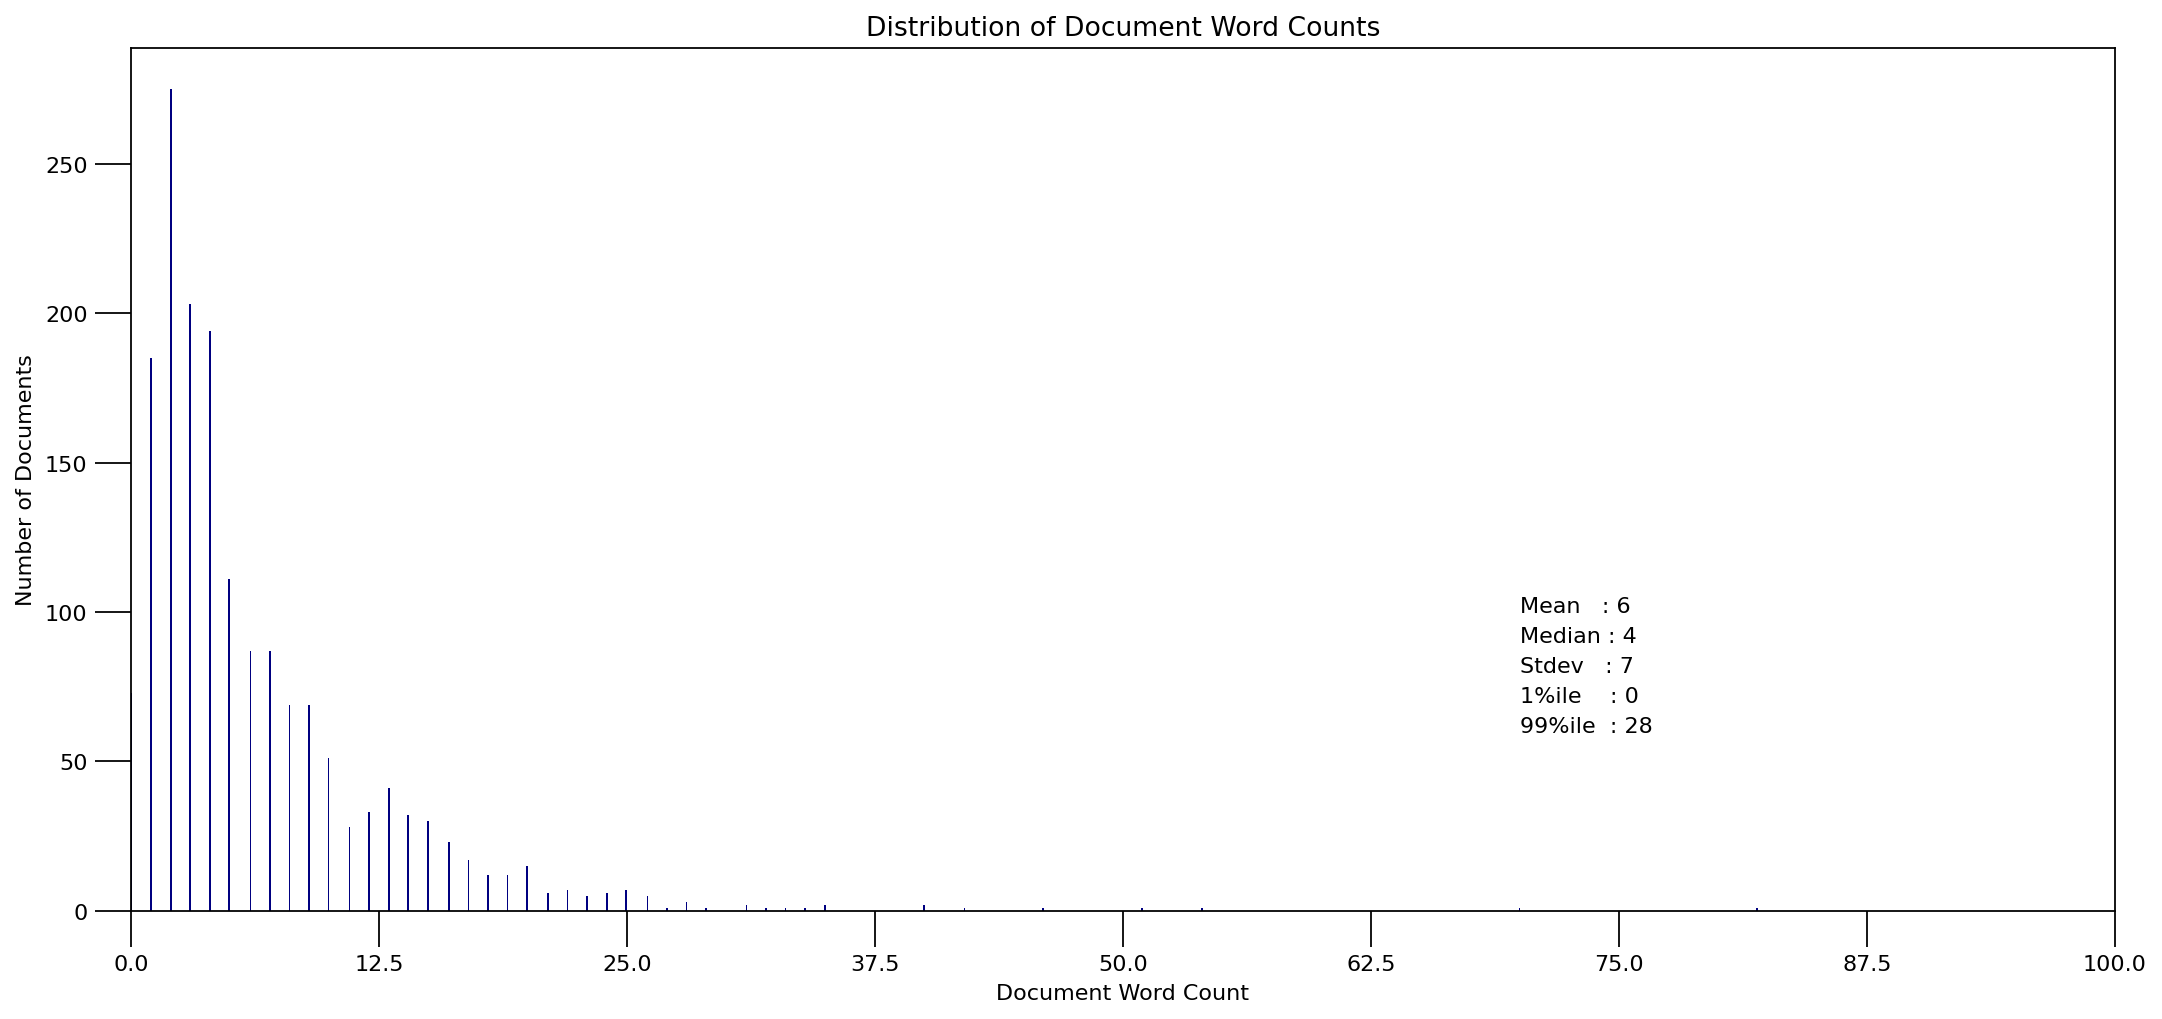

In [ ]:
# @title Let us look at the corpus and output model more precisely:
doc_lens = [len(d) for d in data_ready]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(70, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(70,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(70,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(70,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(70,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts')
plt.show()

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

<ipython-input-21-1f30213da533>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
<ipython-input-21-1f30213da533>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
<ipython-input-21-1f30213da533>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
<ipython-input-21-1f30213da533>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')


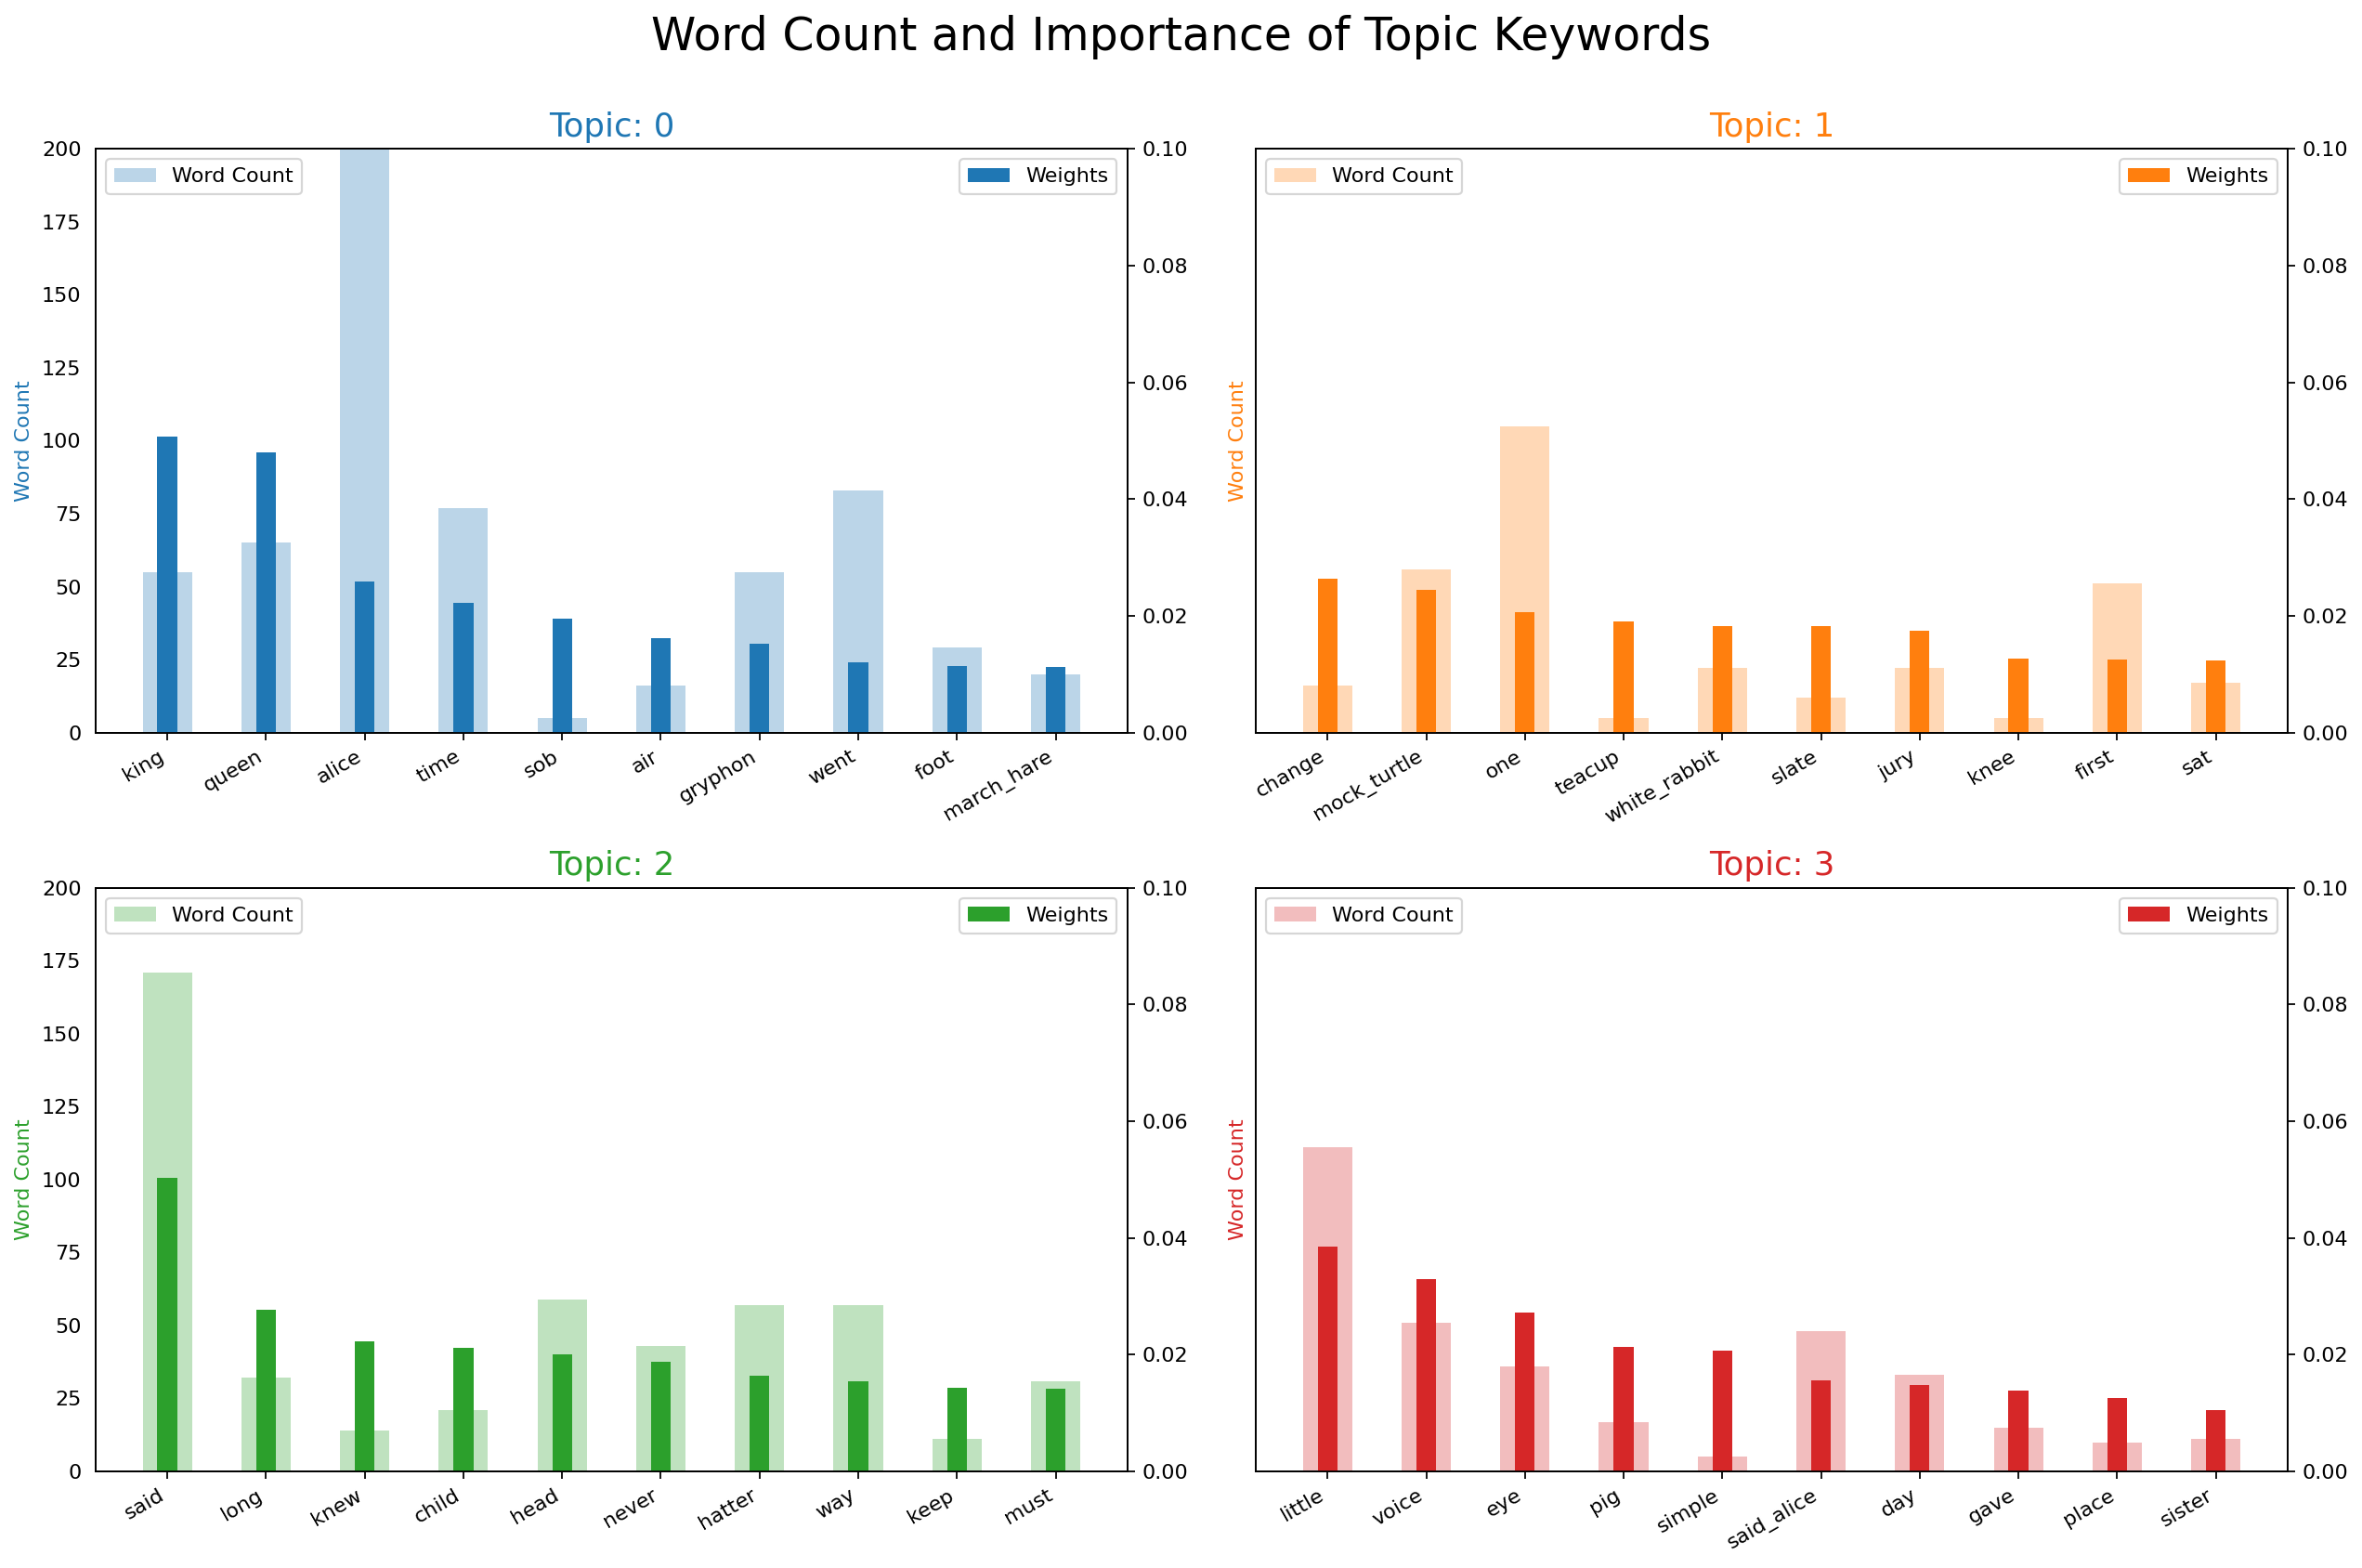

In [ ]:
# @title Plot Word Count and Weights of Topic Keywords
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 200)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

In [ ]:
corp_cur = corpus[13]
topic_percs = np.array(lda_model[corp_cur][0])
topic = np.argmax(topic_percs[:, 1])
topic, topic_percs[topic, 1]

(1, 0.5494772791862488)

In [ ]:
lda_model[corpus[13:15]]

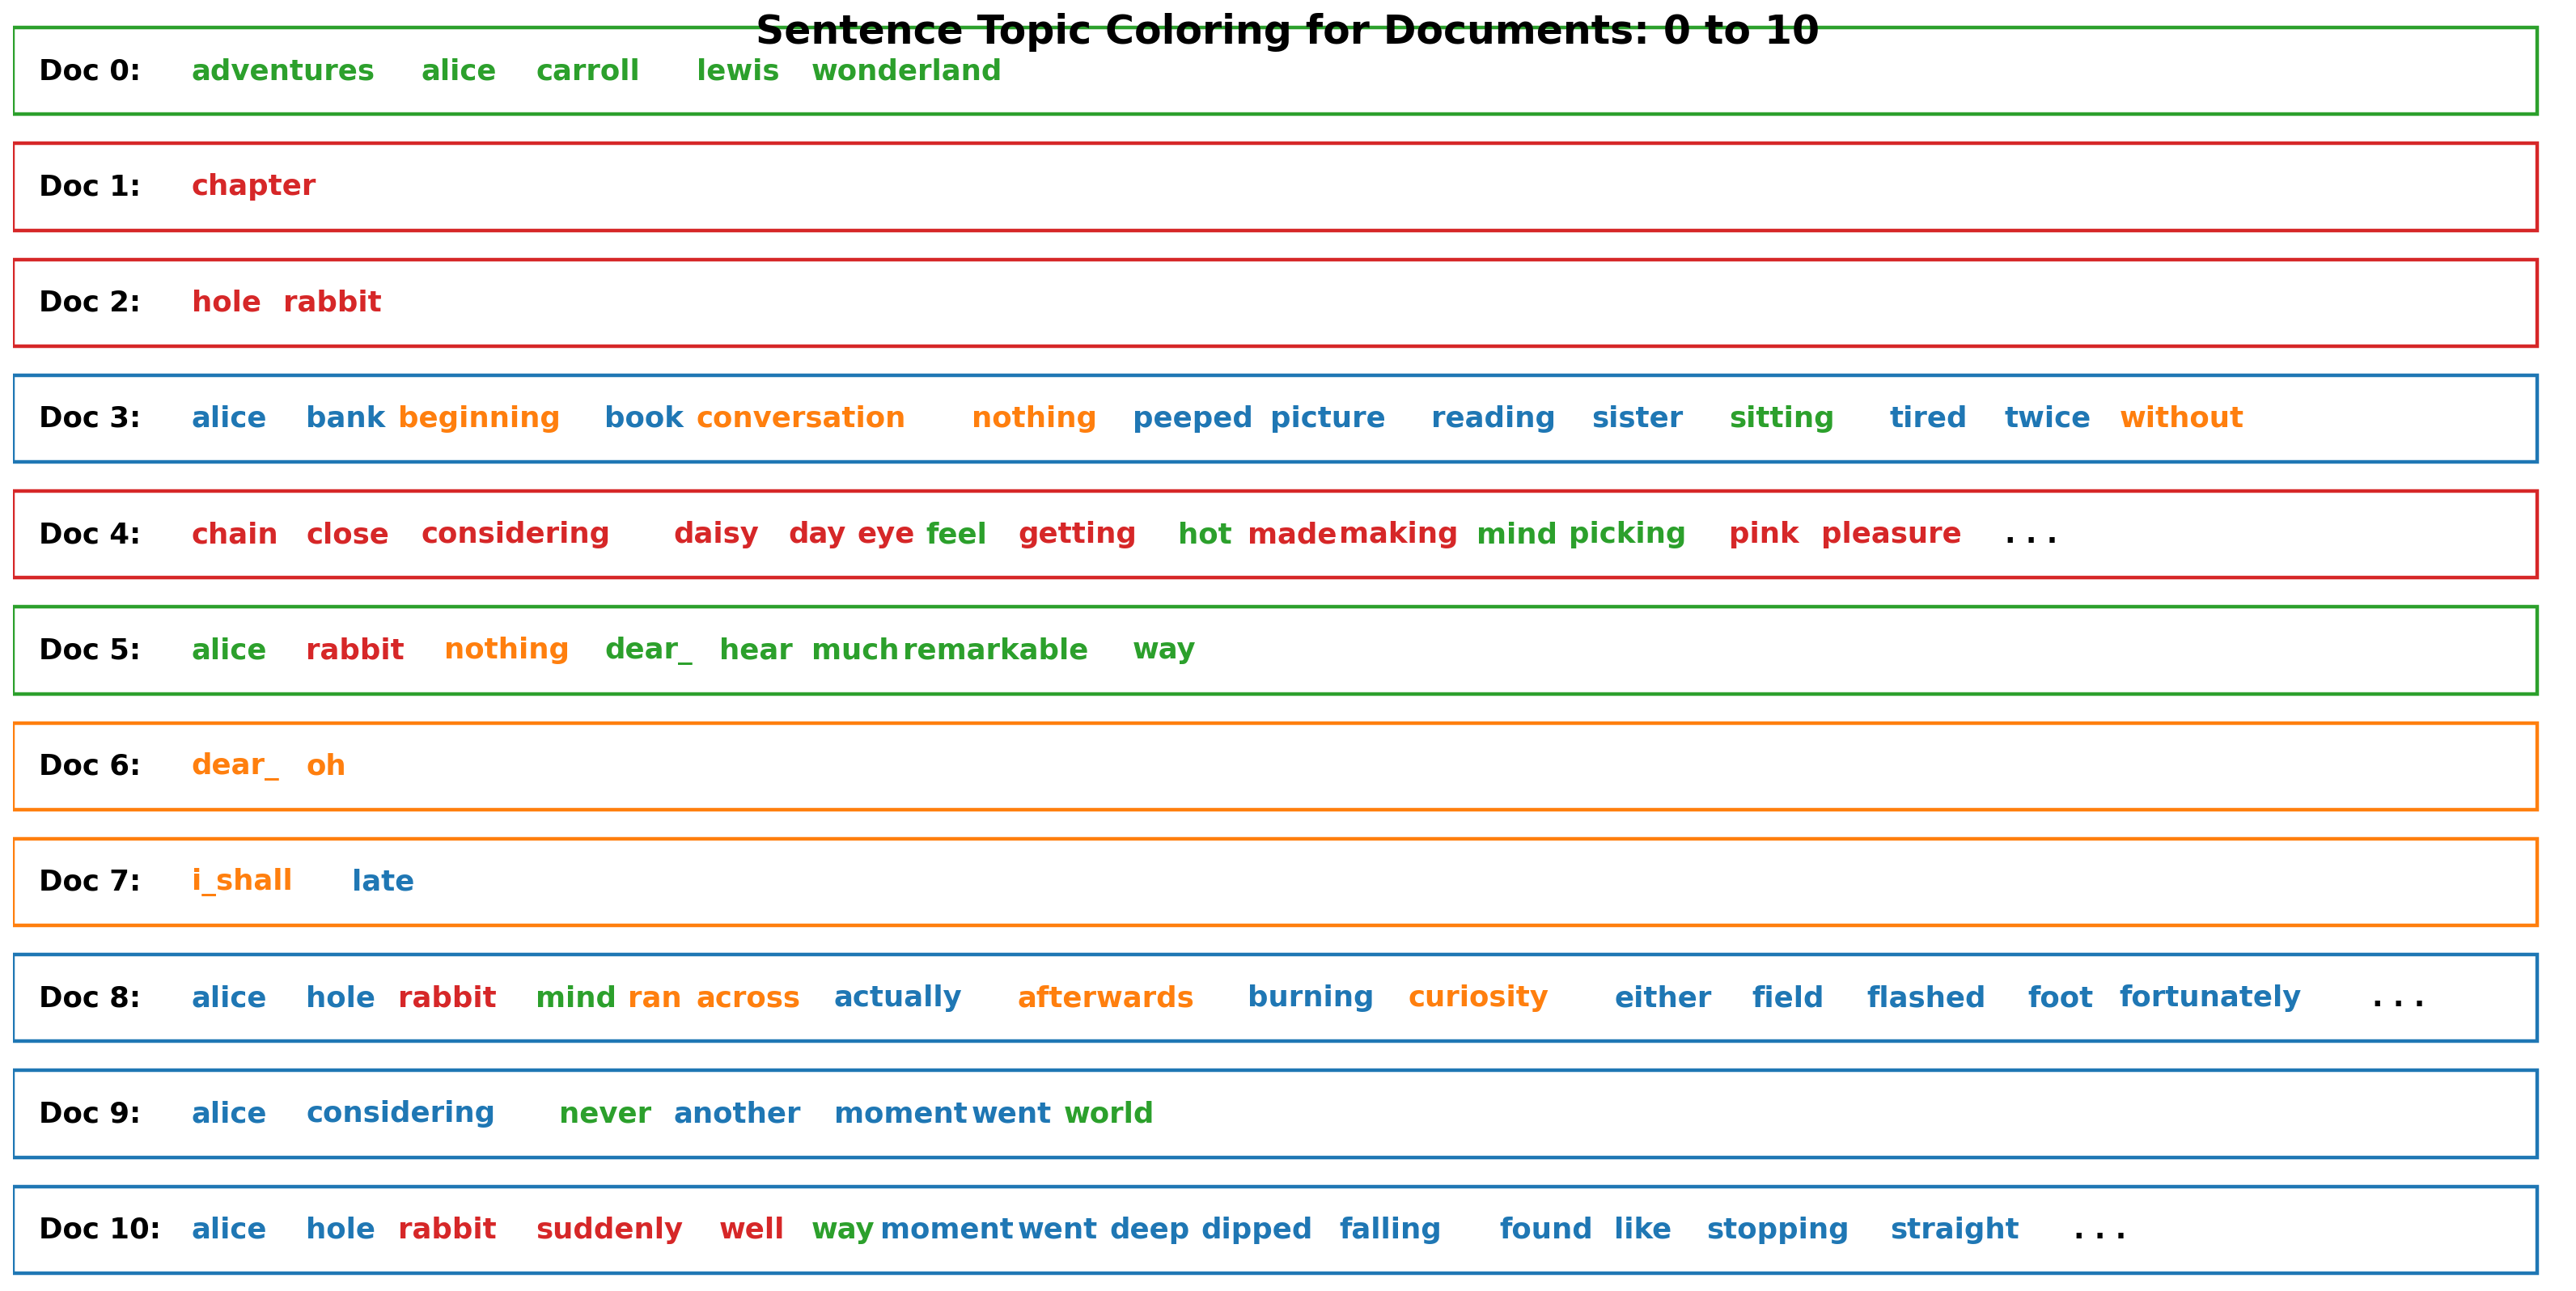

In [ ]:
# @title Sentence Coloring of N Sentences { run: "auto", display-mode: "form" }
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13, words_in_line=15):
    end += 1
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    text_params = dict(horizontalalignment='left', verticalalignment='center', fontsize=16, fontweight=700)

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        corp_cur = corp[i]
        topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
        word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
        ax.axis('off')
        text_params['transform'] = ax.transAxes
        ax.text(0.01, 0.5, f"Doc {start+i}: ",**text_params)

        # Draw Rectange
        topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
        ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

        word_pos = 0.07
        view_len, max_len = sorted([words_in_line, len(word_dominanttopic)])
        for j in range(view_len):
            word, topics = word_dominanttopic[j]
            ax.text(word_pos, 0.5, word, color=mycolors[topics], **text_params)
            word_pos += .009 * len(word)  # to move the word for the next iter
        if max_len > words_in_line:
            ax.text(word_pos, 0.5, '. . .', color='black', **text_params)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-1),
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

start = 0 # @param {type:"integer"}
end = 10 # @param {type:"integer"}
sentences_chart(start=(start or 0), end=(end or 13))

For the final part we need an additional tool for visualization:

In [ ]:
# Install pyLDAVis (specific version for Google Collab)
%pip install -q pyLDAvis==2.1.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import warnings, logging
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word )
vis

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given